# 0. Imports & Utils

In [81]:
import heapq

import cv2
from cv2.ximgproc import guidedFilter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
def display(img):
    
    plt.figure(dpi=100)
    plt.axis("off")
    
    shape = img.shape
    
    gray = False
    if len(shape)==2 or shape[2] == 1:
        gray = True
        
    if np.any(img>1):
#         img = img.astype("uint8")
        pass
    else:
        img = (img*255).astype("uint8")
    
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    
    plt.show()
    return

In [41]:
img = cv2.imread("forest.png").astype('float64')/255

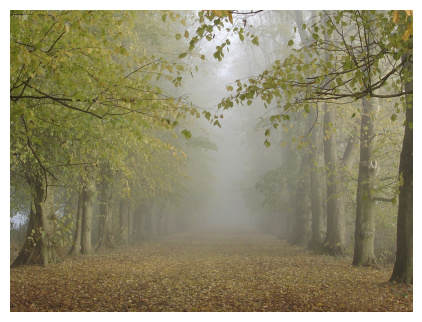

In [42]:
display(img[:, :, ::-1])

# 1. Dark channel computation

In [43]:
PATCH_SIZE=5
MOVE = int(PATCH_SIZE//2)

In [44]:
# dark channel should have the same shape as the original image

out_shape = img.shape
dark_channel = np.zeros((out_shape[0], out_shape[1]), dtype=np.float32)

padded_img = cv2.copyMakeBorder(img, top=PATCH_SIZE//2, bottom=PATCH_SIZE//2,
                                left=PATCH_SIZE//2, right=PATCH_SIZE//2,
                                borderType=cv2.BORDER_REFLECT)

# iterate over all patches
for i in tqdm(range(dark_channel.shape[0] - PATCH_SIZE)):
    for j in range(dark_channel.shape[1] - PATCH_SIZE):
        dark_channel[i, j] = np.min(padded_img[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :])

100%|██████████| 763/763 [00:04<00:00, 167.91it/s]


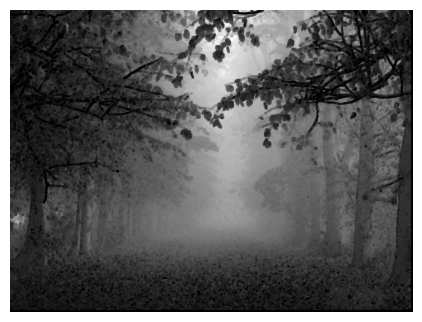

In [46]:
display(dark_channel)

# 2. Atmospheric light computation

Two ways of computing atmospheric light. 
1. The naive way: Use the brightest pixel (This does not consider images that could have a lot of white objects/bright light)
2. Use the dark channel prior as a guide. Choose the average of the brightest dark channel pixels. 

In [78]:
def get_atmospheric_light(img, method="dcp", dc=None, top=0.1):
    """ 
    Takes in an image and returns the atmospheric light
    value estimated from the image. The two allowed methods 
    are: 'brightest' or 'dcp' (for dark channel prior).
    """
    if method == "brightest":
        A = np.zeros(img.shape[-1])
        for c in range(img.shape[-1]):
                A[c] = np.max(img[:, :, c])
        return A
    
    elif method == "dcp":
        assert type(dc)!=type(None), "Need to pass dark channel for this method"
        
        # keep track of the top 0.1% pixels. Use a max heap for that
        h = []
        for i in range(dc.shape[0]):
            for j in range(dc.shape[1]):
                # push the pixel intensity and the location in the heap
                # because ultimately we need the locations of the top 
                # 0.1% pixels
                heapq.heappush(h, (dc[i, j].item(), (i, j)))
        
        num_locs = int(top/100*len(dc.flatten()))
        val_locs = heapq.nlargest(num_locs, h)
        print(f"Considering top {top}% pixels in the dark channel. (i.e., {num_locs}/{len(dc.flatten())})")
        
        # accumulate the pixel locations from the (intensity, location) tuples
        locs = []
        for _, loc in val_locs:
            locs.append(loc)
        
        # find the mean of the intensity values in the original image at these locs
        # (channel-wise computation)
        A = np.zeros(img.shape[-1])
        for x, y in locs:
            A += img[x, y]
        
        A/=num_locs
        
        return A
        
    else:
        print("Incorrect method passed. [Allowed methods: {brightest|dcp}]")
        

In [80]:
A = get_atmospheric_light(img, method="dcp", dc=dark_channel)

print(A)

Considering top 0.1% pixels in the dark channel. (i.e., 786/786432)
[0.96759467 0.93478521 0.92231203]


# 3. Calculate tramission map $\hat{t}$

Transmission is essentially an additive inverse of the dark channel i.e, 
$$\hat{t} = 1 - J$$

This is because low intensity in the dark channel indicates less haze.

The `smoothen` flag performs guided filtering on the transmission map. 
This betters the map generated because the initial map could be somewhat 
"blocky" because of the patch-based processing of the dark channel.

In [83]:
def get_transmission_map(dc, smoothen=True, img=None, omega=0.95):
    """
    Inverts the dark channel passed to it and returns the 
    transmission map. (Optional) Guided-filtering also possible.
    """
    if smoothen:
        assert type(img)!=type(None), "Need input image to perform guided filtering for smoothening"
        t_hat = np.ones(dc.shape, dtype='float64') - (omega * dc)
        
        # smoothen using filtering guided by img
        
        # get the grayscale of the img
        gray = cv2.cvtColor(img.astype("float32"), cv2.COLOR_BGR2GRAY)
        t_hat_refined = guidedFilter(gray, t_hat.astype("float32"), radius=20, eps=10e-3)
        return t_hat_refined
    
    else:
        t_hat = np.ones(dc.shape, dtype='float64') - (omega * dc)
        return t_hat

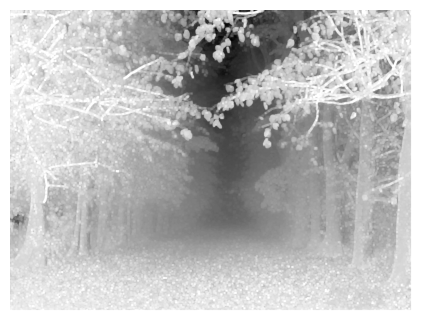

In [100]:
t = get_transmission_map(dark_channel, smoothen=False)
display(t)

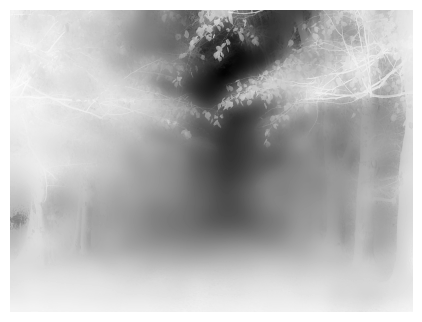

In [109]:
t = get_transmission_map(dark_channel, smoothen=True, img=img)
display(t)

# 4. Recover haze-free image

$$\mathbf{J}(x) = \dfrac{\mathbf{I}(x) - \mathbf{A}}{\max(t(x), t_0)} + \mathbf{A}$$

In [110]:
def recover(img, A, t, t_0=0.1):
    """
    Takes in the image, the atmospheric light, and the
    transmission map and returns the dehazed output
    """
    dehazed = np.zeros(img.shape, dtype='float64')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            dehazed[i, j] = (img[i,j] - A) / max(t[i,j], t_0) 
            dehazed[i, j] += A

    return dehazed

In [111]:
dehazed = recover(img, A, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


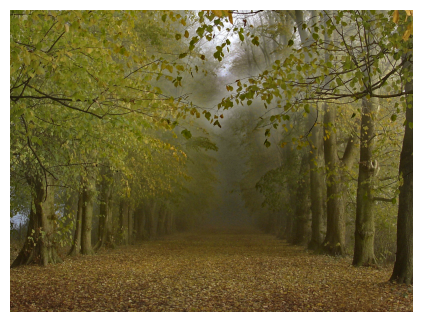

In [112]:
display(dehazed[:, :, ::-1])